In [1]:
%load_ext autoreload
%autoreload 2

# Подготовка данных

Загрузим тексты статей и их векторные представления.

In [2]:
import numpy as np
import pandas as pd

from base.texts import load_papers_df, print_paper

encodings = np.load("data/encodings.npy")
papers = load_papers_df()

print(f"Всего доступно статей: {papers.shape[0]}. Случайная статья:")
print_paper(papers.iloc[np.random.choice(papers.shape[0])])

Всего доступно статей: 74. Случайная статья:
{'Abstract': 'We describe HMNews (Hyper-Media News), a system designed and '
             'implemented for the collection, indexing and retrieval of '
             'hypermedia news content coming from Digital Television and the '
             'Web. The novelty of the approach relies in the ability of '
             'providing hierarchical and multi-resolution multimodal indexes '
             'based on the application of a novel generalised hybrid '
             'clustering technique. The system supports many functionalities: '
             'a) bi-directional news conceptual linking; b) relevant topics '
             'detection and tracking; c) integrated hypermedia browsing; d) '
             'integrated search and retrieval.',
 'Session': 'Information access',
 'Title': 'HMNews: an integrated system for searching and browsing hypermedia '
          'news content'}


# Построение различных моделей графа статей

Построим матрицу расстояний между статьями на основе их векторных представлений.

In [3]:
from base.texts import encodings2distances

distances = encodings2distances(encodings)

Ниже нарисован граф, возникающий при проведении рёбер между 100 парами самых близких статей. Видны две выраженные компоненты.

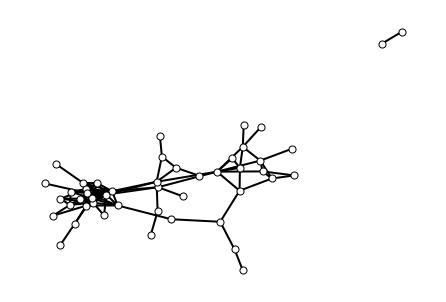

In [4]:
from base.texts import distances2fixed_edges_graph
from base.utils import plot_graph

G = distances2fixed_edges_graph(distances, 100, add_single_nodes=True)
plot_graph(G, plot_single_nodes=False)

Получим различные метрики графа статей в зависимости от количества рёбер.

In [5]:
from tqdm.notebook import trange
from collections import defaultdict
import networkx as nx
from base.utils import graph_features

fixed_edges_features = defaultdict(lambda: [])

for n_edges in trange(papers.shape[0] * (papers.shape[0] - 1) // 2):
    G = distances2fixed_edges_graph(distances, n_edges, add_single_nodes=True)
    for key, val in graph_features(G).items():
        fixed_edges_features[key].append(val)

  0%|          | 0/2701 [00:00<?, ?it/s]

Проведём то же самое для графа статей с фиксированными степенями вершин. На рисунке ниже изображён граф, в котором мы каждую вершину соединяем с тремя ближайшими.

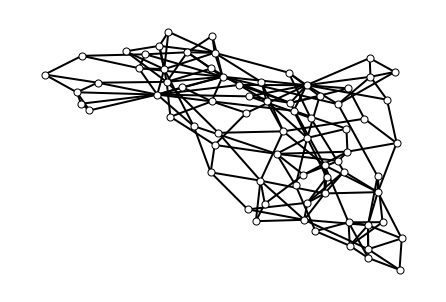

In [6]:
from base.texts import distances2fixed_degree_graph

G = distances2fixed_degree_graph(distances, 3)
plot_graph(G, plot_single_nodes=False)

In [7]:
fixed_degree_features = defaultdict(lambda: [])

for degree in trange(1, papers.shape[0]):
    G = distances2fixed_degree_graph(distances, degree)
    for key, val in graph_features(G).items():
        fixed_degree_features[key].append(val)

  0%|          | 0/73 [00:00<?, ?it/s]

Для сравнения посчитаем всё то же самое для модели графа Эрдёша-Реньи. Поскольку граф строится случайным образом, будем усреднять метрики по нескольким запускам.

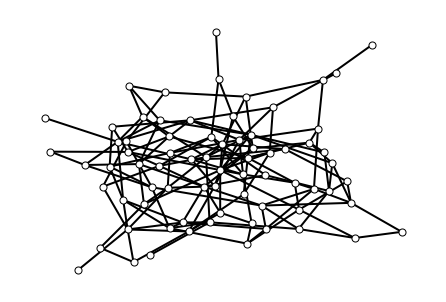

In [8]:
G = nx.erdos_renyi_graph(papers.shape[0], 0.05)
plot_graph(G, plot_single_nodes=False)

In [9]:
from tqdm.notebook import tqdm

erdos_renyi_features = defaultdict(lambda: [])

num_restarts = 100

for p in tqdm(np.arange(0, 1.01, 0.01)):
    feats = defaultdict(lambda: 0.)
    for _ in range(num_restarts):
        G = nx.erdos_renyi_graph(papers.shape[0], p)
        for key, val in graph_features(G).items():
            if val is None or feats[key] is None:
                feats[key] = None
            else:
                feats[key] += val / num_restarts
    for key, val in feats.items():
        erdos_renyi_features[key].append(val)

  0%|          | 0/101 [00:00<?, ?it/s]

# Сравнение метрик

Построим зависимости различных метрик полученных графов от средней степени вершины.

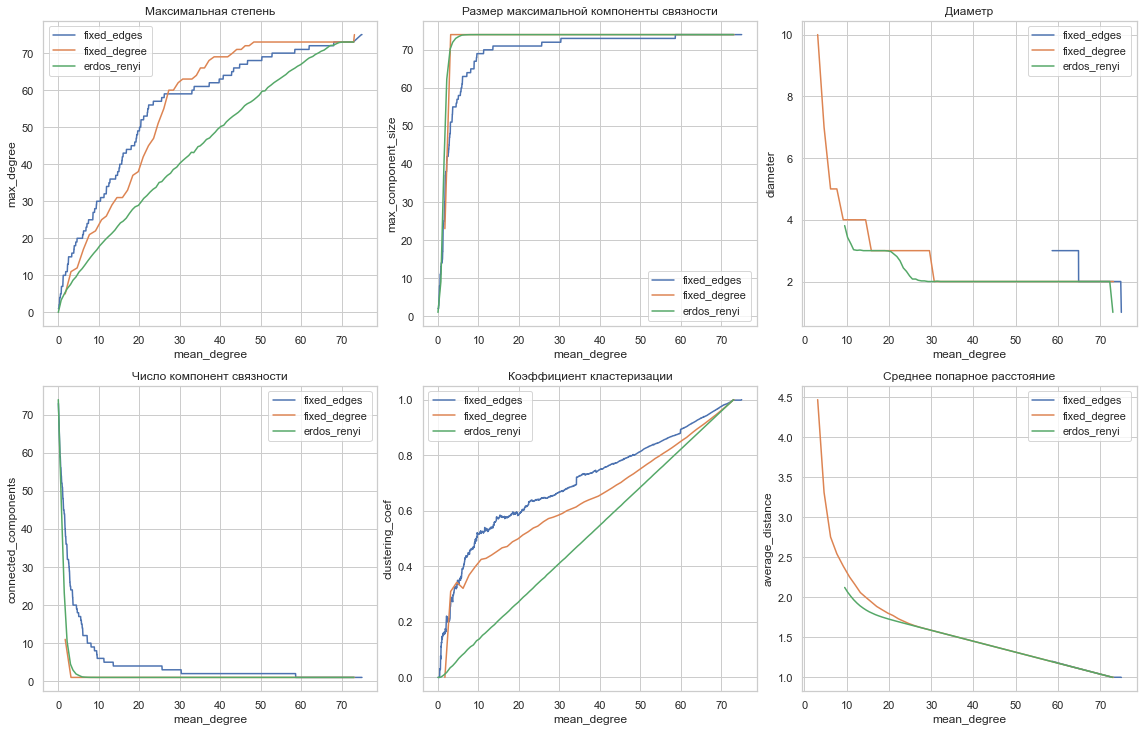

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

titles = {
    "max_degree": "Максимальная степень",
    "connected_components": "Число компонент связности",
    "max_component_size": "Размер максимальной компоненты связности",
    "clustering_coef": "Коэффициент кластеризации",
    "diameter": "Диаметр",
    "average_distance": "Среднее попарное расстояние"
}

f, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))
plt.tight_layout(h_pad=3)

for i, (feature, title) in enumerate(titles.items()):
    sns.lineplot(x=fixed_edges_features["mean_degree"], y=fixed_edges_features[feature], label="fixed_edges",
                 ax=ax[i % 2][i // 2])
    sns.lineplot(x=fixed_degree_features["mean_degree"], y=fixed_degree_features[feature], label="fixed_degree",
                 ax=ax[i % 2][i // 2])   
    sns.lineplot(x=erdos_renyi_features["mean_degree"], y=erdos_renyi_features[feature], label="erdos_renyi",
                 ax=ax[i % 2][i // 2]) 
    ax[i % 2][i // 2].set_title(title)
    ax[i % 2][i // 2].set_xlabel("mean_degree")
    ax[i % 2][i // 2].set_ylabel(feature);

# Разделение итогового графа

Построим итоговый граф статей при помощи выводов, сделанных нами в первой части проекта, разделим его и посмотрим на облака слов по разные стороны разреза.

In [11]:
from base.texts import kernighan_lin_clustering
from base.texts import draw_wordcloud, preprocess_paper_texts

# предобрабатываем тексты, чтобы строить wordclouds
paper_texts = preprocess_paper_texts(papers["title"], papers["abstract"])

G = distances2fixed_degree_graph(distances, 20)
cluster_labels = kernighan_lin_clustering(G)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/data_sapiens/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/data_sapiens/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/data_sapiens/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


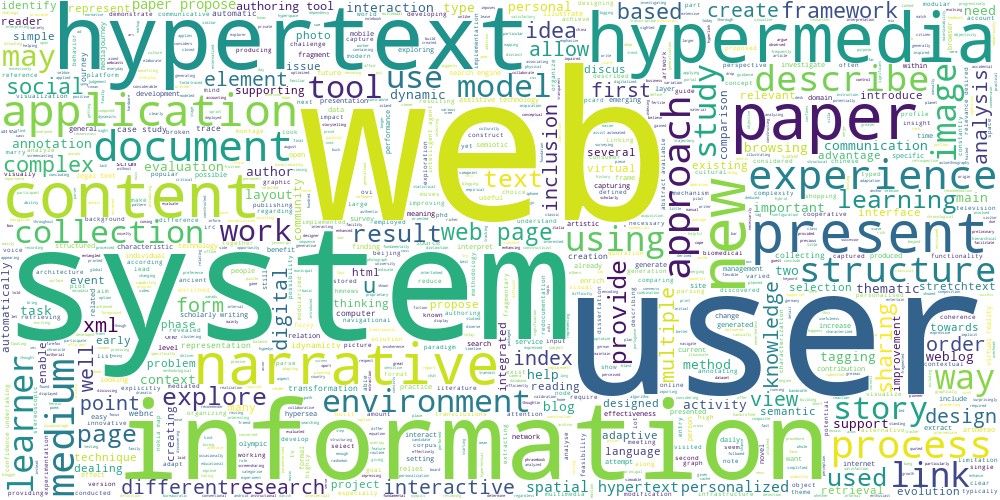

In [12]:
draw_wordcloud(paper_texts[cluster_labels == 0])

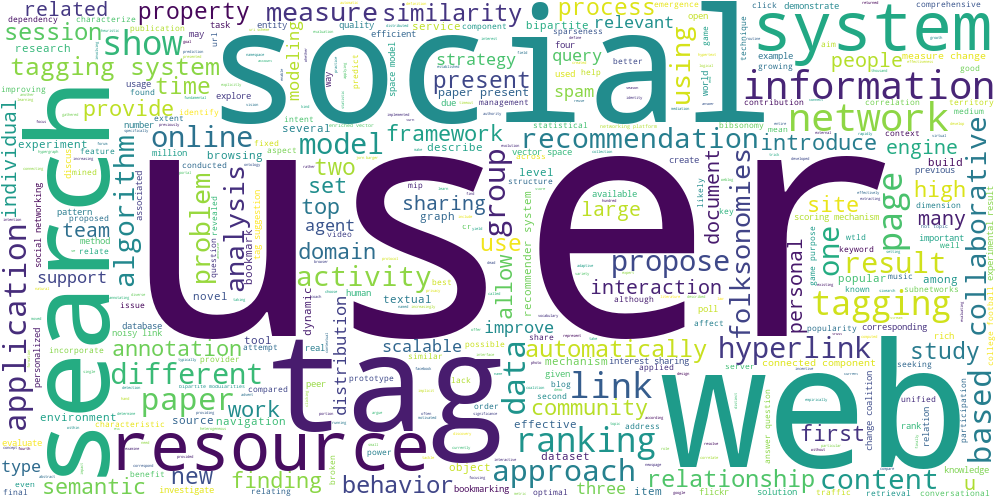

In [13]:
draw_wordcloud(paper_texts[cluster_labels == 1])

Кроме того, можем посмотреть на темы, выделенные LDA.

In [14]:
from base.texts import lda_topics

topics = lda_topics(paper_texts, n_topics=2, n_words=10)
print(f"Тема 1: {topics[0]}\nТема 2: {topics[1]}")

Тема 1: ['web', 'search', 'tag', 'social', 'resource', 'application', 'user', 'page', 'link', 'result']
Тема 2: ['user', 'system', 'web', 'social', 'information', 'paper', 'hypertext', 'content', 'tagging', 'process']
